This notebook contains the code used in order to write this article LINK on climbing Fontainebleau grades.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import sqlite3
import re
import sys
import country_converter as coc
from sklearn.neighbors import KernelDensity
import country_converter as coco
import matplotlib.ticker as mtick
import matplotlib
cc = coco.CountryConverter()
matplotlib.style.use('seaborn')
#matplotlib.style.use('ggplot')

Data downloaded from https://www.kaggle.com/dcohen21/8anu-climbing-logbook.

In [2]:
#SQL querries
file='database.sqlite'
cnx = sqlite3.connect(file)

dfAsc = pd.read_sql_query("SELECT * FROM ascent", cnx)
dfGrade = pd.read_sql_query("SELECT * FROM grade",cnx)
dfMethod = pd.read_sql_query("SELECT * FROM method",cnx)
dfUser = pd.read_sql_query("SELECT * FROM USER",cnx)

Below are the function I used to clean and organize the data.

In [3]:
def GetContinentSerie(sCountry):
    # continent of users who made the ascent
    #in the country list there are some reserved iso3 not in the dictionnary, I manually replace them where it makes sense\n",
    s=sCountry.replace(to_replace=['ROM','FXX'], value=['ROU','FRA'])
    #Methods from cc are too slow, it's faster to use the replace function from pandas
    s=sCountry.replace(to_replace=cc.data.ISO3.to_list(), value=cc.data.continent.to_list())
    return s

def GradeIdToType(serie,dfGrade,sGradeType='fra_boulders'):
    # convert a grade list from grade_id to sGradeType
    s=serie.replace(dfGrade['id'].tolist(),dfGrade[sGradeType].tolist())
    return s

def InsertUniqueRouteId(df):
    #create a unique route id including the fra_grade
    n_unique_route_id=df['crag']+df['name']
    df.insert(1,'unique_route_id',n_unique_route_id)
    return df

def InsertRepeatedRoute(df):
    #insert only repeated routes
    sOnes=np.ones(df.shape[0])
    df.insert(2,'repeated_route',sOnes)
    vCount=df['unique_route_id'].value_counts()
    unverifiedRoutes=set(vCount[vCount==1].index)
    idxUnverifiedRoutes=df['unique_route_id'].isin(unverifiedRoutes)
    df.loc[idxUnverifiedRoutes,'repeated_route']=0
    return df

def GenerateRepeatedAscentDF(dfAscent):
    #generate a df off all repeated ascents in dfAscent
    #using only repeated routes helps prevent erroneous data
    df=InsertRepeatedRoute(InsertUniqueRouteId(dfAscent))
    df.insert(5,'continent',GetContinentSerie(df['country']))
    return df[df['repeated_route']==1]

def GenerateRouteDF(dfAscent,dfGrade):
    #Generate a dataframe containing routes (instead of ascent of routes)
    dfRouteInfo=dfAscent[['crag','name','country','grade_id','crag_id','sector_id','sector','unique_route_id']]
    vc=dfRouteInfo.value_counts()
    df=vc.index.to_frame()
    df.insert(1,'nb_ascent',vc)
    df=df.set_index('unique_route_id')
    df.insert(1,'fra_boulders',GradeIdToType(df['grade_id'],dfGrade,sGradeType='fra_boulders'))
    df.insert(1,'usa_boulders',GradeIdToType(df['grade_id'],dfGrade,sGradeType='usa_boulders'))
    df.insert(5,'continent',GetContinentSerie(df['country']))
    return df

dfBoulderAsc=dfAsc[dfAsc['climb_type']==1].copy()
dfBoulderAsc=dfBoulderAsc[dfBoulderAsc.grade_id<75]# removing manually every problem with grade =< 9A
dfBoulderAscRepeated=GenerateRepeatedAscentDF(dfBoulderAsc)
dfBoulderProblemRepeated=GenerateRouteDF(dfBoulderAscRepeated,dfGrade)
dfBoulderProblem=GenerateRouteDF(InsertUniqueRouteId(dfAsc[dfAsc['climb_type']==1].copy()),dfGrade)

In [4]:
def CreateDFMaxGrade(dfAscent,dfUser):
    #creates a dataframe containing all maxgrade climbed by users that are present in dfAscent and dfUser
    users=np.intersect1d(np.unique(dfAscent['user_id']),dfUser.id.to_numpy()) #only keep users from ascents that appear in the user dataframe
    dfNp=np.zeros((users.shape[0],2))
    dfNp[:,0]=users
    dfMax=pd.DataFrame(dfNp,columns=['user_id','grade_id'])
    dfMax['country']=""
    dfMax['continent']=""

    for i in range(users.shape[0]):
        dfMax.at[i,'grade_id']=np.max(dfAscent[dfAscent['user_id']==users[i]]['grade_id'])
        dfMax.at[i,'country']=dfUser.set_index(dfUser.id).loc[users[i],'country']
    dfMax.insert(1,'fra_boulders',GradeIdToType(dfMax['grade_id'],dfGrade,sGradeType='fra_boulders'))
    dfMax.insert(1,'usa_boulders',GradeIdToType(dfMax['grade_id'],dfGrade,sGradeType='usa_boulders'))
    dfMax.continent=GetContinentSerie(dfMax.country)
    return dfMax

dfMaxRepeated=CreateDFMaxGrade(dfBoulderAscRepeated,dfUser)

Below I select a distribution of grade from the data to draw a graph and calculate it's Kernel density estimation. I used the KDE to get a continous density without curve fitting. I know I expect a rough Gaussian distribution, but the KDE gives follows better the data and I don't need to know the parameters of this distribution for my analysis. The grade range is specified by the variables minGrade and maxGrade.

In [5]:
#Selecting Europe without UK since they use a mix of grading
#df=dfBoulderProblemRepeated #you can do the same analysis with 
df=dfMaxRepeated
df=df[df.country!='GBR'] 
df=df[df.continent=='Europe']
serie=df.fra_boulders

minGrade='5A'
maxGrade='8C+'
s=serie[serie>=minGrade]
s=s[s<=maxGrade]
counts=s.value_counts().sort_index().to_numpy()
counts=counts/np.sum(counts)
[dataDistribution,uniques]=pd.factorize(s,sort=True)
minData=np.min(dataDistribution) #=0
maxData=np.max(dataDistribution)
nbPoint=2001
pointPerGrade=(nbPoint-1)/(maxData-minData)
x = np.linspace(minData, maxData, nbPoint)[:, np.newaxis]
model = KernelDensity(kernel='gaussian',bandwidth=1)
model.fit(dataDistribution.reshape(-1, 1))
dens = np.exp(model.score_samples(x))

Below I draw a graph containing the distribution of the data and the KDE. The range of the graph can be manipulated by the variables subsetModifMin and subsetModifMax.

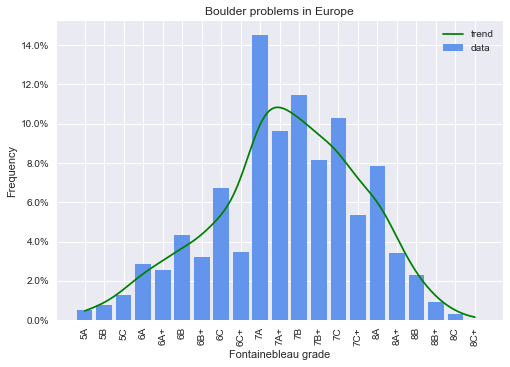

In [6]:
fig, ax1 = plt.subplots()
# change those 2 parameters to change the grade included in the graph
subsetModifMin=0 #number of grades to ignore starting from min grade and going up
subsetModifMax=0 #number of grades to ignore starting from max grade and going down
xBar=np.arange(minData+subsetModifMin, maxData+1-subsetModifMax)
yBar=counts[np.arange(minData+subsetModifMin,maxData+1-subsetModifMax)]
ax1.bar(xBar,yBar*100,color='cornflowerblue',label='data')
xDens=np.linspace(minData+subsetModifMin, maxData-subsetModifMax, int((maxData-subsetModifMax-subsetModifMin)*pointPerGrade))[:, np.newaxis]
yDens=dens[np.arange(int((minData+subsetModifMin)*pointPerGrade),int((maxData-subsetModifMax)*pointPerGrade))]
ax1.plot(xDens,yDens*100,c='green',label='trend')

grades=uniques.to_numpy()
tickSpace=1
gradeLabels=grades[np.arange(subsetModifMin,grades.shape[0]-subsetModifMax,tickSpace)]
ax1.set_xticks(np.arange(subsetModifMin,grades.shape[0]-subsetModifMax,tickSpace))
dump=ax1.set_xticklabels(gradeLabels)
plt.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('Fontainebleau grade')
plt.ylabel('Frequency')
plt.title('Boulder problems in Europe')
dump=plt.xticks(rotation=90)

Graph of the difference between the data and the KDE. 

$Difference(grade)=\frac{data(grade)-trend(grade)}{trend(grade)}*100$

Text(0, 0.5, 'Difference')

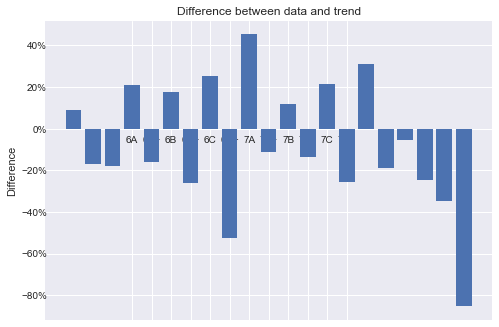

In [7]:
fig, ax = plt.subplots()
diff=np.zeros(maxData+1-subsetModifMax-subsetModifMin)
counts2=counts[subsetModifMin:maxData+1-subsetModifMax]
for i in range(diff.shape[0]):
    diff[i]=((counts2[i])-dens[int((subsetModifMin+i)*pointPerGrade)])/dens[int((subsetModifMin+i)*pointPerGrade)]
ax.bar(xBar,diff*100,label='difference')
startLabel=3
endLabel=grades.shape[0]-6
gradeLabels2=grades[np.arange(startLabel,endLabel,tickSpace)]
ax.set_xticks(np.arange(startLabel,endLabel,tickSpace))
a=ax.set_xticklabels(gradeLabels2)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',subsetModifMin-1))
ax.set_title('Difference between data and trend')
plt.ylabel('Difference')

Below I calculate the average difficulty difference between grades with + and without. I restrict this mesure between 6A to 7C+ because my use of the KDE is not appropriate for the data above around 8B. The KDE is too influenced by the largers number on the left which bring it's value way too high compared to the data.

In [8]:
#for this to work the first value in diff needs to be above 5C and without a +
withoutPlusIndex=np.arange(0,diff.shape[0],2)
withPlusIndex=np.arange(1,diff.shape[0],2)
avgWithout=np.mean(diff[withoutPlusIndex])
avgWith=np.mean(diff[withPlusIndex])
rWo=(1+avgWithout)/(1+avgWith+1+avgWithout)
rW=(1+avgWith)/(1+avgWith+1+avgWithout)
print('The ratio of difficulty for grades without a + is '+format(rWo,'.3f')+'\n and the ratio for grades with a + is '+format(rW,'.3f'))

The ratio of difficulty for grades without a + is 0.400
 and the ratio for grades with a + is 0.600


In [9]:
def ShowGradeDistribution(df,dfGrade,grade_type='fra_boulders',minGrade='5A'):
    #simpler function to show gradedistribution 
    s=df[grade_type]
    s=s.astype('category')
    s=s.cat.set_categories(dfGrade[grade_type].drop_duplicates().to_list(),ordered=True)
    s=s[s>=minGrade]
    vC=s.value_counts()
    vC=vC[vC!=0]
    vC.sort_index().plot.bar()

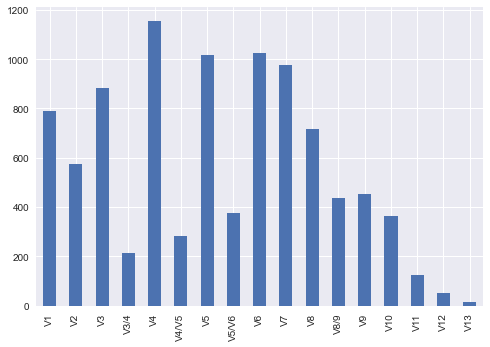

In [10]:
#use of ShowGradeDistribution
df=dfBoulderProblemRepeated
df=df[df.country=='CAN']
ShowGradeDistribution(df,dfGrade,grade_type='usa_boulders',minGrade='V1')